In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


Epoch 0 - Loss: 1.4867
Epoch 2 - Loss: 1.4867
Epoch 4 - Loss: 1.4867
Epoch 6 - Loss: 1.4867
Epoch 8 - Loss: 1.4867


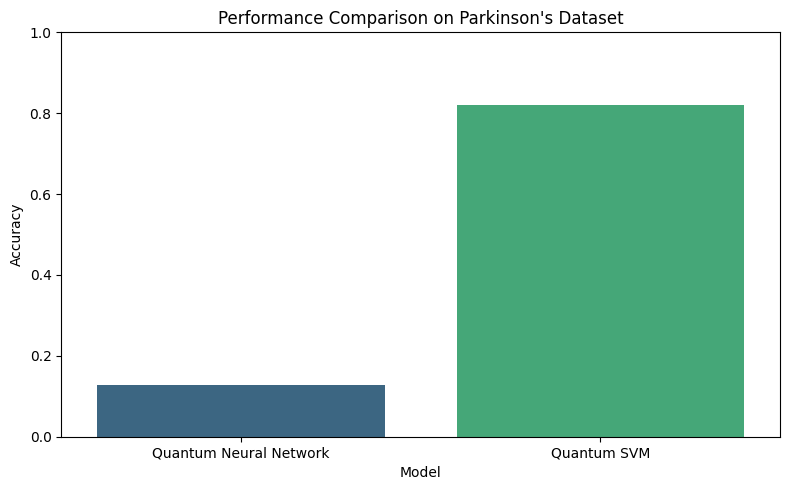

QNN Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.1613    0.7143    0.2632         7
           2     0.0000    0.0000    0.0000        32

    accuracy                         0.1282        39
   macro avg     0.0538    0.2381    0.0877        39
weighted avg     0.0289    0.1282    0.0472        39


QSVM Report:
              precision    recall  f1-score   support

           1     0.5000    0.2857    0.3636         7
           2     0.8571    0.9375    0.8955        32

    accuracy                         0.8205        39
   macro avg     0.6786    0.6116    0.6296        39
weighted avg     0.7930    0.8205    0.8001        39



In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml

# Load Parkinson’s dataset
from sklearn.datasets import fetch_openml
df = fetch_openml(name="parkinsons", version=1, as_frame=True).frame

# Preprocess
if "name" in df.columns:
    df = df.drop(columns=["name"])

X = df.drop(columns=["Class"]).values
y = df["Class"].astype(int).values
X = X[:, :4]  # Use first 4 features

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- QSVM ---
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

@qml.qnode(dev)
def kernel_wrapper(x1, x2):
    return kernel_circuit(x1, x2)

def quantum_kernel(X1, X2):
    return np.array([[kernel_wrapper(x1, x2)[0] for x2 in X2] for x1 in X1])

qk_train = quantum_kernel(X_train, X_train)
qk_test = quantum_kernel(X_test, X_train)

qsvm = SVC(kernel="precomputed")
qsvm.fit(qk_train, y_train)
y_pred_qsvm = qsvm.predict(qk_test)
acc_qsvm = accuracy_score(y_test, y_pred_qsvm)

# --- QNN ---
dev_qnn = qml.device("default.qubit", wires=n_qubits)

def variational_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev_qnn)
def qnn_forward(params, x):
    return variational_circuit(params, x)

class QNNClassifier:
    def __init__(self, n_layers=2, n_qubits=4, epochs=10, lr=0.1):
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.epochs = epochs
        self.lr = lr
        self.params = 0.01 * np.random.randn(n_layers, n_qubits)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict_proba(self, X):
        return np.array([self.sigmoid(qnn_forward(self.params, x)) for x in X])
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)
    
    def loss(self, X, y, params=None):
        if params is None:
            params = self.params
        predictions = np.array([self.sigmoid(qnn_forward(params, x)) for x in X])
        return np.mean((predictions - y) ** 2)
    
    def fit(self, X, y):
        opt = qml.GradientDescentOptimizer(self.lr)
        for epoch in range(self.epochs):
            loss = self.loss(X, y)
            self.params = opt.step(lambda v: self.loss(X, y, v), self.params)
            if epoch % 2 == 0:
                print(f"Epoch {epoch} - Loss: {loss:.4f}")

qnn_clf = QNNClassifier(epochs=10)
qnn_clf.fit(X_train, y_train)
y_pred_qnn = qnn_clf.predict(X_test)
acc_qnn = accuracy_score(y_test, y_pred_qnn)

# --- Plot Results ---
results = pd.DataFrame({
    "Model": ["Quantum Neural Network", "Quantum SVM"],
    "Accuracy": [acc_qnn, acc_qsvm]
})

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=results, palette="viridis")
plt.ylim(0, 1)
plt.title("Performance Comparison on Parkinson's Dataset")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# --- Reports ---
print("QNN Report:")
print(classification_report(y_test, y_pred_qnn, digits=4))

print("\nQSVM Report:")
print(classification_report(y_test, y_pred_qsvm, digits=4))


Epoch 0 - Loss: 0.2339
Epoch 2 - Loss: 0.2339
Epoch 4 - Loss: 0.2339
Epoch 6 - Loss: 0.2339
Epoch 8 - Loss: 0.2339
Epoch 10 - Loss: 0.2339
Epoch 12 - Loss: 0.2339
Epoch 14 - Loss: 0.2339
Epoch 16 - Loss: 0.2339
Epoch 18 - Loss: 0.2339


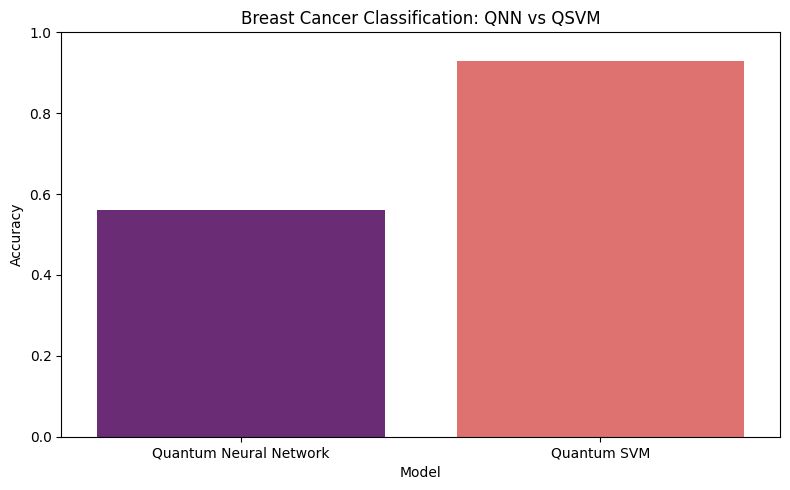

QNN Classification Report:
              precision    recall  f1-score   support

           0     0.1818    0.0465    0.0741        43
           1     0.6019    0.8732    0.7126        71

    accuracy                         0.5614       114
   macro avg     0.3919    0.4599    0.3934       114
weighted avg     0.4435    0.5614    0.4718       114


QSVM Classification Report:
              precision    recall  f1-score   support

           0     0.9070    0.9070    0.9070        43
           1     0.9437    0.9437    0.9437        71

    accuracy                         0.9298       114
   macro avg     0.9253    0.9253    0.9253       114
weighted avg     0.9298    0.9298    0.9298       114



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import pennylane as qml

# Load and preprocess Breast Cancer dataset
data = load_breast_cancer()
X = data.data[:, :4]  # Use only 4 features for 4-qubit quantum circuits
y = data.target

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ------------------------ QSVM ------------------------

n_qubits = 4
dev_qsvm = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_qsvm)
def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

def quantum_kernel(X1, X2):
    return np.array([[kernel_circuit(x1, x2)[0] for x2 in X2] for x1 in X1])

# Quantum kernel matrices
qk_train = quantum_kernel(X_train, X_train)
qk_test = quantum_kernel(X_test, X_train)

# Train QSVM
qsvm = SVC(kernel="precomputed")
qsvm.fit(qk_train, y_train)
y_pred_qsvm = qsvm.predict(qk_test)
acc_qsvm = accuracy_score(y_test, y_pred_qsvm)

# ------------------------ QNN ------------------------

dev_qnn = qml.device("default.qubit", wires=n_qubits)

def variational_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev_qnn)
def qnn_forward(params, x):
    return variational_circuit(params, x)

class QNNClassifier:
    def __init__(self, n_layers=2, n_qubits=4, epochs=10, lr=0.1):
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.epochs = epochs
        self.lr = lr
        self.params = 0.01 * np.random.randn(n_layers, n_qubits)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict_proba(self, X):
        return np.array([self.sigmoid(qnn_forward(self.params, x)) for x in X])

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

    def fit(self, X, y):
        opt = qml.GradientDescentOptimizer(self.lr)
        for epoch in range(self.epochs):
            loss = self.loss(X, y)
            self.params = opt.step(lambda v: self.loss(X, y, v), self.params)
            if epoch % 2 == 0:
                print(f"Epoch {epoch} - Loss: {loss:.4f}")

    def loss(self, X, y, params=None):
        if params is None:
            params = self.params
        predictions = np.array([self.sigmoid(qnn_forward(params, x)) for x in X])
        return np.mean((predictions - y) ** 2)

# Train and evaluate QNN
qnn_clf = QNNClassifier(epochs=20)
qnn_clf.fit(X_train, y_train)
y_pred_qnn = qnn_clf.predict(X_test)
acc_qnn = accuracy_score(y_test, y_pred_qnn)

# ------------------------ Results ------------------------

# Create results dataframe
results = pd.DataFrame({
    "Model": ["Quantum Neural Network", "Quantum SVM"],
    "Accuracy": [acc_qnn, acc_qsvm]
})

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=results, palette="magma")
plt.ylim(0, 1)
plt.title("Breast Cancer Classification: QNN vs QSVM")
plt.tight_layout()
plt.show()

# Classification Reports
print("QNN Classification Report:")
print(classification_report(y_test, y_pred_qnn, digits=4))

print("\nQSVM Classification Report:")
print(classification_report(y_test, y_pred_qsvm, digits=4))
